# Praca domowa 2
## Martyna Majchrzak

In [17]:
library(DALEXtra)

In [8]:
library(OpenML)
library(mlr)
library(DALEX)
library(DALEXtra)
library(ggplot2)
library(gridExtra)
library(lime)
set.seed(1)
diabetes <- getOMLDataSet(data.id = 37L)
diabetes <- diabetes$data

ERROR: Error in library(lime): there is no package called 'lime'


## Zbiór danych

Zbiór danych Diabetes zawiera informacje o osobach chorych na cukrzycę.

1. preg - ile razy dana osoba była w ciąży
2. plas - stężenie glukozy w osoczu po 2h ustnego testu na tolerancję glukozy
3. pres - ciśnienie rozkurczowe (mm Hg)
4. skin - grubość skóry mierzona na tricepsie (mm)
5. insu - 2-Hour serum insulin (mu U/ml)
6. mass - index masy ciała BMI (waga w kg/(wzrost w m)^2)
7. pedi - obciążenie genetyczne (Diabetes pedigree function)
8. age - wiek (lata)
9. class - zmienna celu o wartościach tested_negative oraz tested_positive

## Rozkłady zmiennych

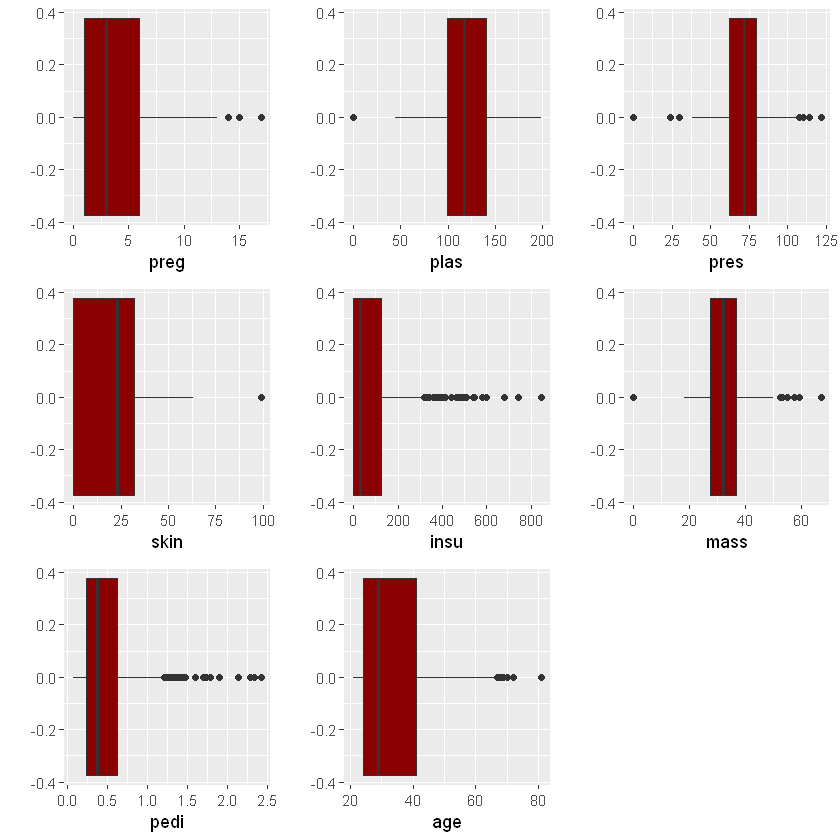

In [2]:
variables <- names(diabetes[,-9])

plots <- lapply(variables, function(variable){
  ggplot(data=diabetes, aes_string(variable)) +
    geom_boxplot(fill='darkred') +
    ylab('')
})

grid.arrange(grobs=plots, ncol=3)

## Tworzenie modelu i explainera

W rozwiązaniu zostanie użyty model Random Forest. Według danych OpenML  ( https://www.openml.org/t/37 ) osiąga on średnio największą wartość miary accuracy.

In [3]:
model_ranger <- ranger::ranger(class~., data = diabetes, classification = TRUE, probability = TRUE)

explainer<- DALEX::explain(model = model_ranger,
                         data = diabetes[,-9],
                         y = as.numeric(diabetes$class=='tested_positive'),
                    colorize = FALSE)

Preparation of a new explainer is initiated
  -> model label       :  ranger  (  default  )
  -> data              :  768  rows  8  cols 
  -> target variable   :  768  values 
  -> model_info        :  package ranger , ver. 0.12.1 , task classification (  default  ) 
  -> predict function  :  yhat.ranger  will be used (  default  )
  -> predicted values  :  numerical, min =  0 , mean =  0.3491104 , max =  0.953319  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.5822087 , mean =  -0.0001521111 , max =  0.6520325  
  A new explainer has been created!  


## Predykcja dla obserwacji 13

Przyjrzyjmy się pacjentce ze szczęśliwym numerem 13. Jest to 57-latka która była w ciąży 10 razy i ma BMI 27,1 (nadwaga).

In [5]:
diabetes[13,]

,preg,plas,pres,skin,insu,mass,pedi,age,class
12,10,139,80,0,0,27.1,1.441,57,tested_negative


In [6]:
prediction13<-predict(model_ranger, diabetes[13,])
prediction13$predictions

tested_negative,tested_positive
0.7534169,0.2465831


Ta osoba z prawdopodobieństwem ok. 0.75 została przypisana do klasy tested_negative (czyli 0.25 do tested_positive)

## LIME

In [19]:
library(DALEXtra)
library(lime)
model_type.dalex_explainer <- DALEXtra::model_type.dalex_explainer
predict_model.dalex_explainer <- DALEXtra::predict_model.dalex_explainer
lime_ranger13 <- predict_surrogate(
  explainer = explainer,
  new_observation = diabetes[13,-9], 
  n_features = 3, 
  n_permutations = 1000,
  type = "lime")

plot(lime_ranger13)

ERROR: Error: 'model_type.dalex_explainer' is not an exported object from 'namespace:DALEXtra'


Według wyjaśnienia prawdopodobieństwo pozytywnego testu obniżał fakt, że pacjentka miała BMI poniżej 27,3, a podwyższała wartość funkcji obciążenia genetycznego większa od 0,626 i to, że pacjentka była w ciąży więcej niż 6 razy.

Podejrzany wydaje się fakt, że mimo nadwagi zmienna mass obniżała tak znacznie ryzyko wystąpienia cukrzycy.
Przyjrzyjmy się rozkładowi tej zmiennej.

In [ ]:
boxplot(diabetes$mass, horizontal = TRUE)
mean(diabetes$mass)

Średnia zmiennej mass wynosi prawie 32, co oznacza otyłość, zdarzają się też przypadki powyżej 40, co oznacza otyłość kliniczną.

![BMI chart](BMI_chart.jfif)

Zatem nasza pacjentka na tym tle nie wypada tak źle.

## LIME dla różnych obserwacji

### Obserwacja 26

In [ ]:
diabetes[26,]

Pacjentka ma 41 lat, była w ciąży 10 razy, ma BMI 31,1 i chorowała na cukrzycę.

In [ ]:
lime_ranger26 <- predict_surrogate(
  explainer = explainer,
  new_observation = diabetes[26,-9], 
  n_features = 3, 
  n_permutations = 1000,
  type = "lime")

plot(lime_ranger26)

Tą pacjentkę model z prawdopodobieństwem 65% zaklasyfikowałby jako chorą, na co wpływa ponownie duża liczba ciąży oraz wiek powyżej 29 lat. Tym razem wartość funkcji obciążenia genetycznego jest jednak dość niska, co obniża prawdopodobieństwo wystąpienia cukrzycy.

### Obserwacja 39

In [ ]:
diabetes[39,]

Pacjentka ma 27 lat, była w ciąży 2 razy, ma BMI 382, i chorowała na cukrzycę.

In [ ]:
lime_ranger39 <- predict_surrogate(
  explainer = explainer,
  new_observation = diabetes[39,-9], 
  n_features = 3, 
  n_permutations = 1000,
  type = "lime")

plot(lime_ranger39)

U tej pacjentki model nieprawidłowo przewidział to, czy pacjentka jest chora, ale był całkiem blisko (43%). Prawdopodobieństwo to bardzo zwiększyło wysokie BMI, ale niemal równie mocno obniżył niskie stężenie glukozy (`plas`, średnia ok.120). Bardzo nieznacznie zmniejszyło je też to, że była w ciąży tylko 2 razy.

### Obserwacja 52

In [ ]:
diabetes[52,]